In [1]:
import netCDF4
import pandas
import datetime
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import signal, ndimage
%matplotlib inline

In [2]:
minCutoffFitLat = 45.
delTimeCutOffNrstPass = 45 # min
mlonDiffOtrEndCutoff = 50.
delLatCutoff = 2.
delCtimeCutoff = 60. #min
gauss_smooth_sigma = 5. # Roughly corresponds to 1 deg in MLAT
diffElctrCutoffBnd = 0.1

In [3]:
fileList = [ "../poes_n15_20130302_proc.nc",\
                "../poes_n18_20130302_proc.nc",\
                "../poes_m01_20130302_proc.nc",\
                "../poes_n19_20130302_proc.nc",\
                "../poes_m01_20130302_proc.nc",\
                "../poes_n16_20130302_proc.nc",\
                "../poes_n17_20130302_proc.nc" ]
poesAllEleDataDF = pandas.DataFrame( columns =  ["timestamp", "date", "aacgm_lat_foot",\
                         "aacgm_lon_foot", "MLT", "log_ele_flux", "sat"] )
poesAllProDataDF = pandas.DataFrame( columns =  ["timestamp", "date", "aacgm_lat_foot",\
                         "aacgm_lon_foot", "MLT", "log_pro_flux", "sat"] )
for f in fileList:
    print "reading file-->", f
    # read variable from the netCDF files
    poesRawData = netCDF4.Dataset(f)
    poesDF = pandas.DataFrame( poesRawData.variables['time'][:], columns=[ "timestamp" ] )
    poesDF['date'] = pandas.to_datetime(poesDF['timestamp'], unit='ms')
    poesDF["alt"] = poesRawData.variables['alt'][:]
    poesDF["aacgm_lat_foot"] = poesRawData.variables['aacgm_lat_foot'][:]

    poesDF["aacgm_lon_foot"] = poesRawData.variables['aacgm_lon_foot'][:]
    poesDF["MLT"] = poesRawData.variables['MLT'][:]
    # round of to 2 decimals
    poesDF['alt'] = [ round( x, 2 ) for x in poesDF['alt']]
    poesDF['aacgm_lat_foot'] = [ round( x, 2 ) for x in poesDF['aacgm_lat_foot']]
    poesDF['aacgm_lon_foot'] = [ round( x, 2 ) for x in poesDF['aacgm_lon_foot']]
    poesDF['MLT'] = [ round( x, 2 ) for x in poesDF['MLT']]
    # Add up the fluxes
    poesDF["ted_ele_total_flux"] = poesRawData.variables['ted_ele_tel0_flux_4'][:] +\
            poesRawData.variables['ted_ele_tel0_flux_8'][:] + \
            poesRawData.variables['ted_ele_tel0_flux_11'][:] + \
            poesRawData.variables['ted_ele_tel0_flux_14'][:] + \
            poesRawData.variables['ted_ele_tel30_flux_4'][:] +\
            poesRawData.variables['ted_ele_tel30_flux_8'][:] + \
            poesRawData.variables['ted_ele_tel30_flux_11'][:] + \
            poesRawData.variables['ted_ele_tel30_flux_14'][:]
    poesDF["ted_pro_total_flux"] = poesRawData.variables['ted_pro_tel0_flux_4'][:] +\
            poesRawData.variables['ted_pro_tel0_flux_8'][:] + \
            poesRawData.variables['ted_pro_tel0_flux_11'][:] + \
            poesRawData.variables['ted_pro_tel0_flux_14'][:] + \
            poesRawData.variables['ted_pro_tel30_flux_4'][:] +\
            poesRawData.variables['ted_pro_tel30_flux_8'][:] + \
            poesRawData.variables['ted_pro_tel30_flux_11'][:] + \
            poesRawData.variables['ted_pro_tel30_flux_14'][:]
    poesDF['log_ele_flux'] = [0. if x <= 0. else round( numpy.log10(x), 2 )\
                 for x in poesDF['ted_ele_total_flux']]
    poesDF['log_pro_flux'] = [0. if x <= 0. else round( numpy.log10(x), 2 )\
                 for x in poesDF['ted_pro_total_flux']]
    # the current satellite number
    poesDF["sat"] = f[-19:-17]
#     seperate out electron and proton flux and discard all zeros
    currPoesEleFluxDF = poesDF[poesDF["log_ele_flux"] > 0.][ ["timestamp",\
                     "date", "aacgm_lat_foot", "aacgm_lon_foot", "MLT",\
                     "log_ele_flux", "sat"] ].reset_index(drop=True)
    currPoesProFluxDF = poesDF[poesDF["log_pro_flux"] > 0.][ ["timestamp",\
                     "date", "aacgm_lat_foot", "aacgm_lon_foot", "MLT",\
                     "log_pro_flux", "sat"] ].reset_index(drop=True)
    
    
    poesAllEleDataDF = poesAllEleDataDF.append( currPoesEleFluxDF )
    poesAllProDataDF = poesAllProDataDF.append( currPoesProFluxDF )
    # now delete all the rows for prev DFs
    # we don't want to duplicate data
    poesDF = poesDF.drop( poesDF.index )
    currPoesEleFluxDF = currPoesEleFluxDF.drop( currPoesEleFluxDF.index )
    currPoesProFluxDF = currPoesProFluxDF.drop( currPoesProFluxDF.index )
# create a date and time columns
poesAllEleDataDF["dateStr"] = poesAllEleDataDF["date"].map(lambda x: x.strftime('%Y%m%d'))
poesAllEleDataDF["time"] = poesAllEleDataDF["date"].map(lambda x: x.strftime('%H%M'))
poesAllProDataDF["dateStr"] = poesAllProDataDF["date"].map(lambda x: x.strftime('%Y%m%d'))
poesAllProDataDF["time"] = poesAllProDataDF["date"].map(lambda x: x.strftime('%H%M'))

reading file--> ../poes_n15_20130302_proc.nc
reading file--> ../poes_n18_20130302_proc.nc
reading file--> ../poes_m01_20130302_proc.nc
reading file--> ../poes_n19_20130302_proc.nc
reading file--> ../poes_m01_20130302_proc.nc
reading file--> ../poes_n16_20130302_proc.nc
reading file--> ../poes_n17_20130302_proc.nc


In [4]:
#   sat              start_time                end_time
# 0  01 2013-03-02 03:26:54.755 2013-03-02 03:55:02.752
# 1  16 2013-03-02 04:28:24.986 2013-03-02 04:55:20.987
# 2  17 2013-03-02 03:56:16.193 2013-03-02 04:21:50.193
# 3  18 2013-03-02 03:10:09.132 2013-03-02 03:31:43.132
# 4  19 2013-03-02 04:42:44.994 2013-03-02 05:08:46.993

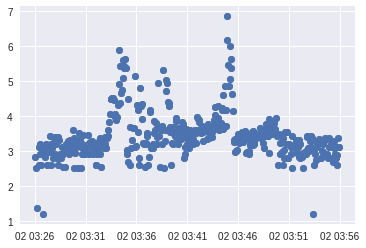

In [5]:
selSat = "01"
selStTime = datetime.datetime( 2013,3,2,3,26 )
selEndTime = datetime.datetime( 2013,3,2,3,56 )
testDF = poesAllEleDataDF[ (poesAllEleDataDF["sat"] == selSat) &\
                         (poesAllEleDataDF["date"] >= selStTime) &\
                         (poesAllEleDataDF["date"] <= selEndTime)].reset_index(drop=True)
testProDF = poesAllProDataDF[ (poesAllProDataDF["sat"] == selSat) &\
                         (poesAllProDataDF["date"] >= selStTime) &\
                         (poesAllProDataDF["date"] <= selEndTime)].reset_index(drop=True)
# plt.plot_date( testDF["date"], testDF["log_ele_flux"] )
plt.plot_date( testDF["date"], testDF["log_ele_flux"] )

In [6]:
# Divide satellite data to two passes
# we'll get boundary data from each pass
# In the first pass, sat is moving from 
# low to high latitudes and in the second one
# We'll get the opposite case
testDF = testDF.sort_values( ["sat","date"],\
                ascending=[True, True] \
                ).reset_index(drop=True)
# We'll get the the satellite pass which is moving polewards
# Basically percent change in latitudes should be positive
# for a satellite moving polewards.
testDF["latRowDiffs"] = testDF.groupby("sat")[[\
                "aacgm_lat_foot" ] ].pct_change()
testDFPolewards = testDF[\
                        testDF["latRowDiffs"] > 0.\
                        ].reset_index(drop=True)
testDFEquatorwards = testDF[\
                        testDF["latRowDiffs"] < 0.\
                        ].reset_index(drop=True)
# print testDFPolewards[ ["date", "aacgm_lat_foot", "MLT", "latRowDiffs", "log_ele_flux"] ]


In [7]:
# Get laplacian of gaussian for poleward pass
datePoleArr = testDFPolewards["date"].values
mlatPoleArr = testDFPolewards["aacgm_lat_foot"].values
eleFluxPoleArr = testDFPolewards["log_ele_flux"].values
filtEleFluxPoleArr = ndimage.filters.gaussian_filter1d(eleFluxPoleArr,gauss_smooth_sigma) #
diffEleFluxPoleArr = numpy.gradient(numpy.gradient(filtEleFluxPoleArr))
# Get laplacian of gaussian for Equatorward pass
dateEquatorArr = testDFEquatorwards["date"].values
mlatEquatorArr = testDFEquatorwards["aacgm_lat_foot"].values
eleFluxEquatorArr = testDFEquatorwards["log_ele_flux"].values
filtEleFluxEquatorArr = ndimage.filters.gaussian_filter1d(eleFluxEquatorArr,gauss_smooth_sigma) #
diffEleFluxEquatorArr = numpy.gradient(numpy.gradient(filtEleFluxEquatorArr))
# Now get the max and min indices (of 
# Laplacian of Gaussian of electron flux) 
# for poleward and equatorward passes
# Poleward
minPolePassLoc = numpy.argmin(diffEleFluxPoleArr)
maxPolePassLoc = numpy.argmax(diffEleFluxPoleArr)
# Equatorward
minEquatorPassLoc = numpy.argmin(diffEleFluxEquatorArr)
maxEquatorPassLoc = numpy.argmax(diffEleFluxEquatorArr)
# Now we calculate the equatorward boundary currently
# We'll only choose the sharpest edge (could be poleward
# or equatorward edge). For the equatorward boundary, we 
# can simply get the nearest (in lat) point where 
# diffEleFluxPoleArr is 10% or less in magnitude.
selLocPolePass = min( minPolePassLoc, maxPolePassLoc )
selLocEquatorPass = max( minEquatorPassLoc, maxEquatorPassLoc )

polePassEqBndLocs = numpy.where( abs(diffEleFluxPoleArr) <= \
                        abs(diffEleFluxPoleArr[selLocPolePass])*diffElctrCutoffBnd )
polePassEqBndLocs = polePassEqBndLocs[0]
equatorPassEqBndLocs = numpy.where( abs(diffEleFluxEquatorArr) <= \
                        abs(diffEleFluxEquatorArr[selLocEquatorPass])*diffElctrCutoffBnd )
equatorPassEqBndLocs = equatorPassEqBndLocs[0]
# Now choose the closest (equatorward/earlier value) 
# which was less than selLocPolePass
polePassEqBndLocInds = numpy.where( polePassEqBndLocs < selLocPolePass )
polePassEqBndLocInds = numpy.max( polePassEqBndLocInds[0] )
polePassEqBndLocs = polePassEqBndLocs[polePassEqBndLocInds]
# get the date parameter to retreive other vars
dateSelPolePassEqBnd = datePoleArr[ polePassEqBndLocs ]
# Now choose the closest (poleward/later value) 
# which was less than selLocEquatorPass
equatorPassEqBndLocInds = numpy.where( equatorPassEqBndLocs > selLocEquatorPass )
equatorPassEqBndLocInds = numpy.min( equatorPassEqBndLocInds[0] )
equatorPassEqBndLocs = equatorPassEqBndLocs[equatorPassEqBndLocInds]
# get the date parameter to retreive other vars
dateSelEquatorPassEqBnd = dateEquatorArr[ equatorPassEqBndLocs ]

print polePassEqBndLocs, diffEleFluxPoleArr[polePassEqBndLocs]
print equatorPassEqBndLocs, diffEleFluxEquatorArr[equatorPassEqBndLocs]

print dateSelPolePassEqBnd, dateSelEquatorPassEqBnd

# print selLocPolePass, selLocEquatorPass, diffEleFluxPoleArr[selLocPolePass]
# print minPolePassLoc, maxPolePassLoc, filtEleFluxPoleArr[minPolePassLoc],filtEleFluxPoleArr[maxPolePassLoc]
# print minEquatorPassLoc, maxEquatorPassLoc, diffEleFluxPoleArr[minPolePassLoc],diffEleFluxPoleArr[maxPolePassLoc]

117 0.000236145951132
78 0.00142855315426
2013-03-02T03:34:08.755000000 2013-03-02T03:46:16.753000000


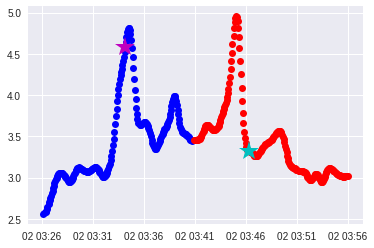

In [8]:
plt.plot_date( datePoleArr, filtEleFluxPoleArr, 'bo' )
plt.plot_date( dateEquatorArr, filtEleFluxEquatorArr, 'ro' )
plt.plot_date( dateSelPolePassEqBnd, filtEleFluxPoleArr[polePassEqBndLocs], 'm*', markersize=20 )
plt.plot_date( dateSelEquatorPassEqBnd, filtEleFluxEquatorArr[equatorPassEqBndLocs], 'c*', markersize=20 )

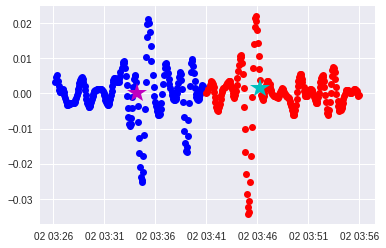

In [14]:
plt.plot_date( datePoleArr, diffEleFluxPoleArr, 'bo' )
plt.plot_date( dateSelPolePassEqBnd, diffEleFluxPoleArr[polePassEqBndLocs], 'm*', markersize=20 )
plt.plot_date( dateEquatorArr, diffEleFluxEquatorArr, 'ro' )
plt.plot_date( dateSelEquatorPassEqBnd, diffEleFluxEquatorArr[equatorPassEqBndLocs], 'c*', markersize=20 )